In [1]:
import torch
import os
import gzip
import pickle
import time
import numpy as np 

from torchvision import datasets, transforms

## Load and examine dataset

In [2]:
""" Load the dataset
Code adapted from http://deeplearning.net/tutorial/code/logistic_sgd.py

:type dataset: string
:param dataset: the path to the dataset (here MNIST)
"""
# Download the MNIST dataset if it is not present
dataset = "mnist.pkl.gz"

data_dir, data_file = os.path.split(dataset)
if data_dir == "" and not os.path.isfile(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(
        os.path.split(__file__)[0],
        dataset
    )
    if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
        dataset = new_path

if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
    from six.moves import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

print('Loading data...')

# Load the dataset
with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
# train_set, valid_set, test_set format: tuple(input, target)
# input is a numpy.ndarray of 2 dimensions (a matrix), np.float32
# where each row corresponds to an example. target is a
# numpy.ndarray of 1 dimension (vector), np.int64 that has the same length
# as the number of rows in the input. It should give the target
# to the example with the same index in the input.
print('Loaded train_set, valid_set and test_set.')

Loading data...
Loaded train_set, valid_set and test_set.


In [3]:
# Build the CNN model
import torch.nn as nn
import torch.nn.functional as F
 
class myMLP(nn.Module):
    def __init__(self):
        super(myMLP, self).__init__()
        # affine
        self.W1 = nn.Parameter(torch.randn(784, 256))
        self.W2 = nn.Parameter(torch.randn(256, 100))
        self.W3 = nn.Parameter(torch.randn(100, 10))
        
        self.b1 = nn.Parameter(torch.randn(256))
        self.b2 = nn.Parameter(torch.randn(100))
        self.b3 = nn.Parameter(torch.randn(10))
        # relu
        self.relu = nn.ReLU()
 
    def forward(self, x):
        # affine -> relu
        x = self.relu(torch.matmul(x, self.W1) + self.b1)
        x = self.relu(torch.matmul(x, self.W2) + self.b2)
        # affine    
        x = torch.matmul(x, self.W3) + self.b3
        return x


In [4]:
batch_size = 64

train_set = (torch.from_numpy(train_set[0]).float(), torch.from_numpy(train_set[1]).long())
valid_set = (torch.from_numpy(valid_set[0]).float(), torch.from_numpy(valid_set[1]).long())
test_set = (torch.from_numpy(test_set[0]).float(), torch.from_numpy(test_set[1]).long())

train_dataset = torch.utils.data.TensorDataset(train_set[0], train_set[1])
valid_dataset = torch.utils.data.TensorDataset(valid_set[0], valid_set[1])
test_dataset = torch.utils.data.TensorDataset(test_set[0], test_set[1])
 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
model = myMLP()
criterion = nn.CrossEntropyLoss()
learning_rate = 1.0e-3
n_epochs = 20

train_loss_list = []
train_acc_list = []
valid_acc_list = []
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# start time
start_time = time.time()

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch+1, n_epochs))
    
    model.eval()
    train_correct = 0
    train_total = 0 
    for data, target in train_loader:
        output = model(data)
        _, pred = torch.max(output, 1)
        train_correct += (pred == target).sum().item()
        train_total += target.size(0)
    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    print('Train accuracy: {:.4f}'.format(train_acc))
    
    valid_correct = 0
    valid_total = 0
    for data, target in valid_loader:
        output = model(data)
        _, pred = torch.max(output, 1)
        valid_correct += (pred == target).sum().item()
        valid_total += target.size(0)
    
    valid_acc = valid_correct / valid_total
    valid_acc_list.append(valid_acc)
    print('Validation accuracy: {:.4f}'.format(valid_acc))
    
    model.train()
    loss_sum = 0
    batch_num = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        batch_num += 1
    print("loss_sum: ", loss_sum, "batch_num: ", batch_num)
    average_loss = loss_sum / batch_num
    train_loss_list.append(average_loss)
    print('Train loss: {:.4f}'.format(average_loss))
    
# end time
end_time = time.time()
print('Total time: {:.2f} minutes'.format((end_time - start_time)/60))

Epoch 1/20
Train accuracy: 0.0734
Validation accuracy: 0.0710


In [ ]:
import json
with open("results/pytorch_mlp.json", "w") as f:
    json.dump({
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "valid_acc": valid_acc_list
    }, f)

In [ ]:
def predict(model, dataloader):
    
    # set the model to evaluation mode
    model.eval()
    
    # make predictions
    predictions = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            output = model(inputs)
            _, pred = torch.max(output, 1)
            predictions.extend(pred.cpu().numpy())
    
    return predictions


ValueError: axes don't match array

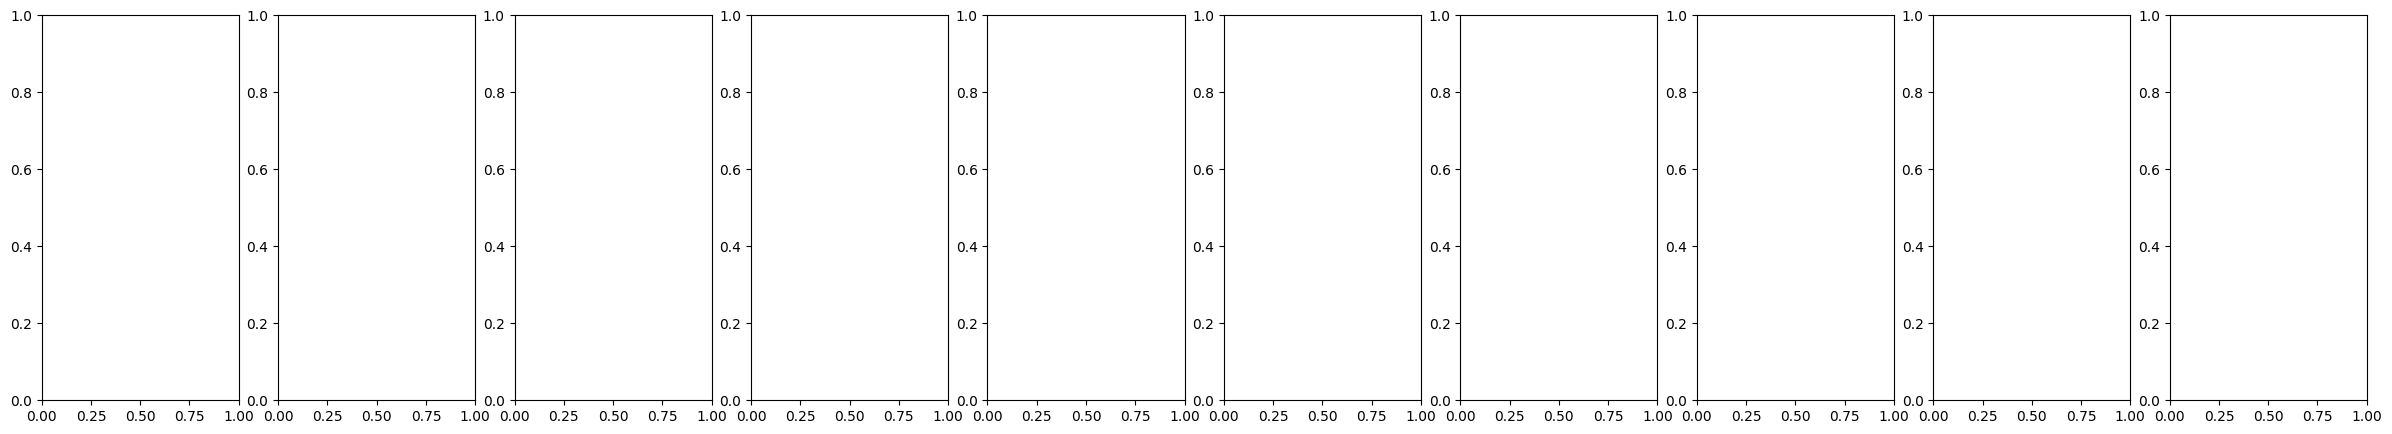

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# get some predictions
predictions = predict(model, test_loader)

# select some random samples
n_samples = 10
sample_indices = np.random.choice(len(test_set[0]), n_samples)

# plot the samples and their predicted labels
fig, axs = plt.subplots(1, n_samples, figsize=(30, 5))
for i, idx in enumerate(sample_indices):
    image = test_set[0][idx].numpy().transpose(1, 2, 0)
    label = test_set[1][idx].item()
    predicted_label = predictions[idx]
    axs[i].imshow(image)
    axs[i].set_title(f"true: {label}, predicted: {predicted_label}")
    axs[i].axis('off')
plt.show()
